
- 20240536 Inês Jacinto 20240536@novaims.unl.pt
- 20240561 Antônio Ramos 20240561@novaims.unl.pt 
- 20240598 Sofia Jacinto 20240598@novaims.unl.pt 
- 20240750 Marisa Marques 20240750@novaims.unl.pt

In [1]:
#General Imports
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer,  classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# Loading the dataset after EDA (Exploratory Data Analysis)
train_df = pd.read_csv("train_data_after_EDA.csv")

In [3]:
#Droping 'Accident Date' and 'Birth Year' as we did in the EDA
train_df = train_df.drop(["Accident Date", "Birth Year"], axis=1 )
# Checking for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545204 entries, 0 to 545203
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Claim Identifier                545204 non-null  int64  
 1   Age at Injury                   545204 non-null  float64
 2   Alternative Dispute Resolution  545204 non-null  int64  
 3   Attorney/Representative         545204 non-null  int64  
 4   Average Weekly Wage             518012 non-null  float64
 5   Carrier Name                    545204 non-null  float64
 6   Carrier Type                    545204 non-null  int64  
 7   Claim Injury Type               545204 non-null  int64  
 8   County of Injury                545204 non-null  float64
 9   COVID-19 Indicator              545204 non-null  int64  
 10  District Name                   545204 non-null  float64
 11  Gender                          545204 non-null  float64
 12  IME-4 Count     

In [4]:
# Separating the independent variables (X) and the target variable (y) for the model
X = train_df.drop(["Claim Injury Type"], axis = 1)
y = train_df["Claim Injury Type"]

In [5]:
# Splitting the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Features with missing values
missValMean = ['Age at Injury','Average Weekly Wage', 'Years Past Accident','Assembly Years past Accident']
missValMode = ['Industry Code']

In [7]:
# Filling the missing values with the mean for the numeric features, for both train and test sets
X_train[missValMean] = X_train[missValMean].fillna(X_train[missValMean].mean())

In [8]:
X_test[missValMean] = X_test[missValMean].fillna(X_test[missValMean].mean())

In [9]:
# Filling the missing values with the mode for the categorical features, for both train and test sets
X_train[missValMode] = X_train[missValMode].fillna(X_train[missValMode].mode())

In [10]:
X_test[missValMode] = X_test[missValMode].fillna(X_test[missValMode].mode())

In [11]:
# Scaling the columns with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Filling the rest of the missing values with the mean of that collumn, in case there are any
X_train_scaled = np.nan_to_num(X_train_scaled, nan=np.nanmean(X_train_scaled, axis=0))
X_test_scaled = np.nan_to_num(X_test_scaled, nan=np.nanmean(X_test_scaled, axis=0))

## Using an unbalenced class weight

In [13]:
# Logistic Regression with K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(
    multi_class='multinomial', 
    max_iter=1000,
    verbose=1, 
    random_state=42)

In [14]:
f1_scorer = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=f1_scorer)

print(f"F1-scores per Fold: {f1_scores}")
print(f"Average F1-score: {np.mean(f1_scores):.2f}")

F1-scores per Fold: [0.69791079 0.69860934 0.69898661 0.69770486 0.69908371]
Average F1-score: 0.70


In [15]:
# Adjusting the model in the training set and using f1_score to evaluate its performance
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(f"F1-score in the test set: {f1_score(y_test, y_pred, average='weighted'):.2f}")

F1-score in the test set: 0.70


#### Applying GridSearchCV

In [16]:
# GridSearchCV for hiperparameters otimization
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l2'], 
    'solver': ['lbfgs']   
}

In [17]:
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42, solver='lbfgs'),
    param_grid,
    scoring=f1_scorer,
    cv=5
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [18]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-score in training (cross-val): {grid_search.best_score_:.2f}")

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1-score in training (cross-val): 0.70


In [19]:
# Choosing the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
print(f"F1-score of the best model in the test set: {f1_score(y_test, y_pred_best, average='weighted'):.2f}")

F1-score of the best model in the test set: 0.70


In [20]:
# Printing the classification report
report = classification_report(y_test, y_pred_best)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.39      0.51      2058
           1       0.82      0.96      0.88     54802
           2       0.29      0.07      0.11     13469
           3       0.65      0.81      0.73     28514
           4       0.60      0.37      0.45      9280
           5       0.00      0.00      0.00       821
           6       0.00      0.00      0.00        21
           7       0.50      0.20      0.28        76

    accuracy                           0.74    109041
   macro avg       0.45      0.35      0.37    109041
weighted avg       0.69      0.74      0.70    109041



## Using a balanced class weight

In [21]:
# Logistic Regression with K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(
    multi_class='multinomial', 
    max_iter=1000,
    verbose=1, 
    random_state=42,
    class_weight="balanced"
)

In [22]:
f1_scorer = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=f1_scorer)

print(f"F1-scores per Fold: {f1_scores}")
print(f"Average F1-score: {np.mean(f1_scores):.2f}")

F1-scores per Fold: [0.61332977 0.61329024 0.61716396 0.60982238 0.61224416]
Average F1-score: 0.61


In [23]:
# Adjusting the model in the training set and using f1_score to evaluate its performance
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(f"F1-score in the test set: {f1_score(y_test, y_pred, average='weighted'):.2f}")

F1-score in the test set: 0.61


#### Applying GridSearchCV

In [24]:
# GridSearchCV for hiperparameters otimization
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2'],      
    'solver': ['lbfgs']    
}

In [25]:
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42, solver='lbfgs', class_weight="balanced"),
    param_grid,
    scoring=f1_scorer,
    cv=5
)

In [26]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [27]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-score in training (cross-val): {grid_search.best_score_:.2f}")

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1-score in training (cross-val): 0.61


In [28]:
# Choosing the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

In [29]:
# Printing the classification report
report = classification_report(y_test, y_pred_best)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.67      0.31      2058
           1       0.88      0.85      0.86     54802
           2       0.21      0.22      0.21     13469
           3       0.75      0.26      0.39     28514
           4       0.48      0.53      0.51      9280
           5       0.05      0.48      0.09       821
           6       0.00      0.67      0.01        21
           7       0.02      0.88      0.04        76

    accuracy                           0.58    109041
   macro avg       0.32      0.57      0.30    109041
weighted avg       0.71      0.58      0.61    109041



#### Applying the Principal Components Analysis (PCA)

Principal Components selected: 5
Cumulative explained variance: 0.44

 Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.54      0.34      2058
           1       0.74      0.80      0.77     54802
           2       0.20      0.16      0.18     13469
           3       0.43      0.09      0.16     28514
           4       0.35      0.41      0.37      9280
           5       0.04      0.40      0.07       821
           6       0.00      0.67      0.01        21
           7       0.01      0.67      0.02        76

    accuracy                           0.50    109041
   macro avg       0.25      0.47      0.24    109041
weighted avg       0.54      0.50      0.49    109041



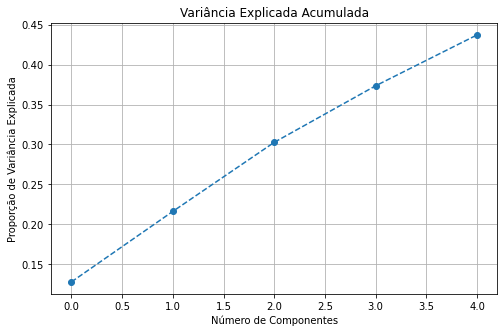

Principal Components selected: 9
Cumulative explained variance: 0.62

 Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.55      0.38      2058
           1       0.75      0.78      0.76     54802
           2       0.20      0.19      0.19     13469
           3       0.45      0.11      0.18     28514
           4       0.37      0.44      0.40      9280
           5       0.04      0.35      0.07       821
           6       0.00      0.57      0.01        21
           7       0.01      0.70      0.02        76

    accuracy                           0.50    109041
   macro avg       0.26      0.46      0.25    109041
weighted avg       0.55      0.50      0.50    109041



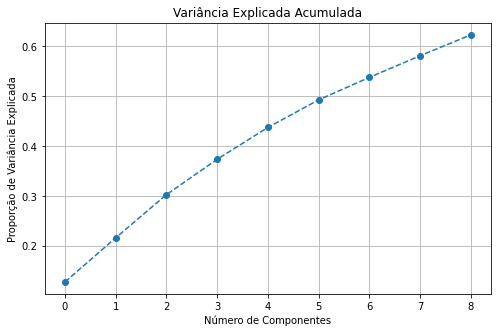

Principal Components selected: 13
Cumulative explained variance: 0.78

 Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.64      0.30      2058
           1       0.87      0.81      0.84     54802
           2       0.20      0.24      0.22     13469
           3       0.67      0.22      0.33     28514
           4       0.48      0.44      0.46      9280
           5       0.04      0.38      0.08       821
           6       0.00      0.76      0.01        21
           7       0.01      0.71      0.02        76

    accuracy                           0.55    109041
   macro avg       0.31      0.53      0.28    109041
weighted avg       0.68      0.55      0.58    109041



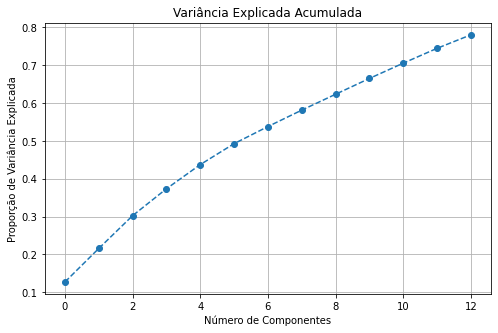

Principal Components selected: 17
Cumulative explained variance: 0.89

 Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.64      0.25      2058
           1       0.87      0.82      0.85     54802
           2       0.19      0.22      0.20     13469
           3       0.70      0.21      0.33     28514
           4       0.45      0.49      0.47      9280
           5       0.05      0.41      0.09       821
           6       0.00      0.76      0.01        21
           7       0.01      0.82      0.03        76

    accuracy                           0.55    109041
   macro avg       0.30      0.55      0.28    109041
weighted avg       0.69      0.55      0.58    109041



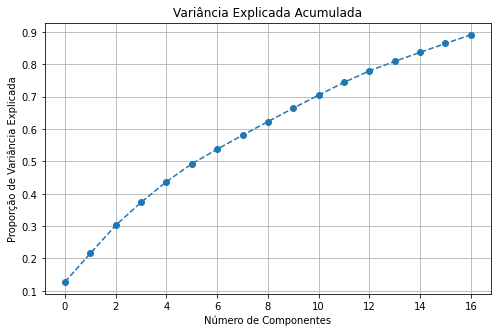

Principal Components selected: 21
Cumulative explained variance: 0.97

 Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.66      0.32      2058
           1       0.88      0.85      0.86     54802
           2       0.21      0.23      0.22     13469
           3       0.74      0.26      0.38     28514
           4       0.48      0.50      0.49      9280
           5       0.05      0.48      0.09       821
           6       0.00      0.62      0.01        21
           7       0.02      0.87      0.04        76

    accuracy                           0.58    109041
   macro avg       0.32      0.56      0.30    109041
weighted avg       0.70      0.58      0.61    109041



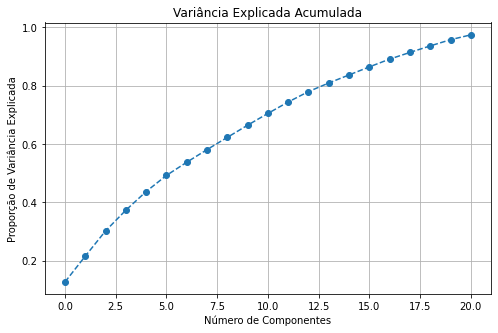

In [30]:
for i in range(5, 25, 4):
    pca = PCA(n_components=i) 
    
    # Applying the PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Choosing the number of principal components
    print(f"Principal Components selected: {pca.n_components_}")
    print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")
    
    # Training the model with the chosen components
    model =LogisticRegression(
        multi_class="multinomial", 
        max_iter=1000,
        verbose=1, 
        random_state=42,
        class_weight="balanced"
    )
    model.fit(X_train_pca, y_train)
    
    # Evaluate the model performance in the test set
    y_pred = model.predict(X_test_pca)
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    explained_variance = pca.explained_variance_ratio_
    
    # Cumulative explained variance graphic
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.title('Variância Explicada Acumulada')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Proporção de Variância Explicada')
    plt.grid()
    plt.show()